# 4G/5G Wireless Network Simulation

**Please note** : This project makes use of two custom libraries, namely:


```Hexalattice```         :       Used for plotting the hexagonal grids for 4G and 5G Networks  
```Celluloid```           :       Simple framework for capturing animation and rendering to video


These may be installed using pip as

```pip install hexalattice celluloid```

In an anaconda environment, they may be installed through the Conda Forge by adding it as a channel

```
conda config --add channels conda-forge
conda config --set channel_priority strict
conda install hexalattice celluloid
```

## Imports defined here


**Please note:** `bisect` is used to perform binary search operations in the grid assignment function

In [1]:
#Table manipulation inclusions

import numpy as np
import pandas as pd


#Mathematical function inclusions

import math

# Graphing inclusions
import matplotlib.pyplot as plt
from hexalattice import hexalattice as hxlat


#Utility inclusions
import bisect


#Animation
from celluloid import Camera

In [2]:
from IPython.display import HTML

## Reproducibility 

May be set by uncommenting the line below

In [3]:
# Fixing random state for reproducibility
#np.random.seed(19680801)

## Constant Definitions

Constants are grouped by purpose : animation, colours used for graphing, network parameters by technology (4G / 5G), and user parameters. Constants and functions have been defined to adhere to Self Commenting Code principles. In general, variables use the convention `variable_name` while functions use `functionName`.

In [4]:
animation_duration_s = 30
seconds_per_frame = 0.2
kpi_fail_frames = 0

In [5]:
#Colour definitions go here

user_edgeclr = (0, 0, 0, 0.8)
user_faceclr = (0, 0, 0, 0.2)

user_pltsize = 5

marker_4g = 'o'
marker_5g = '^'

user_faces =  [
                '#99444680',
                '#af894680',
                '#a5b75280',
                '#42964380',
                '#40a09a80'   ]


user_edges =  [
                '#994446FF',
                '#af8946FF',
                '#a5b752FF',
                '#429643FF',
                '#40a09aFF'   ]

nw_edges_4g = [0.57, 0.6, 0.6, 0.9]
nw_faces_4g = [0.57, 0.6, 0.6, 0.1]
nw_edges_5g = [0.27, 0.52, 0.49, 0.8]
nw_faces_5g = [0.27, 0.52, 0.49, 0.05]



# Utility Constant Definitions

## Physical Constants

In [6]:
#Mathematical + Physical Constants go here

K_boltz = (1.3806503 * (10**-23))
T_0 = 293.16


## Hash Constants

Simple hash function to assign mathematically a unique identifier to each cell in the grid 

The chosen expression is:

```
HASH = hash_a + ( hash_eval_x )  + ( hash_eval_y )
```
Where

```
hash_eval_x = hash_x * x * sign(x) * hash_sgn_x
hash_eval_y = hash_y * y * sign(y) * hash_sgn_y

```

In [7]:
#Utility variables go here

hash_a = 211
hash_x = 53
hash_y = 91
hash_sgn_x = 71
hash_sgn_y = 79

In [8]:
#Scaling values go here

f_scale = (10**9)               # Frequency multiplier - Default 10^9 == GHz
units_per_km = 1                # Maps distance to Cartesian scale - Default 1 : 1 unit == 1 km. 1000 : 1 unit = 1m

# Network Constants defined here

## 4G Specific constants

In [9]:
#Network specific values go here

link_dbm_4g = 23
freq_lte = 1.5
noise_floor_4g = -90

#tower specific constants go here

tower_grid_4g =	{   'x' : 7     ,    'y': 7     }
num_towers_4g = tower_grid_4g['x'] * tower_grid_4g['y']
range_4g = 2                    # Maximum cell cize - 4G

outage_prob_4g = 0.01

## 5G Specific Constants

In [10]:
link_dbm_5g = 30
freq_5g = 15
noise_floor_5g = -80

tower_grid_5g = tower_grid_4g
num_towers_5g = num_towers_4g

range_5g = 0.6
gap_ratio_4g_5g = (range_4g - range_5g)/(range_4g)

outage_prob_5g = 0.1

## Common Network Constants

In [11]:
rician_mean_loss_4g = 2
rician_loss_offset_db = 2
rayleigh_mean_loss_4g = 2
rayleigh_prob_4g = 0.1


seconds_per_outage_update = 2
iters_per_outage_update = int(seconds_per_outage_update/seconds_per_frame)

iters_per_reporting_update = int(iters_per_outage_update/2)

# User Specific Constants

In [12]:
#User specific constants here
num_users = 400
max_vel = 60*units_per_km/1000

user_range = {
    'x_min' : -1*(tower_grid_4g['x']),
    'x_max' :    (tower_grid_4g['x']-1), 
    'y_min' : -1*(tower_grid_4g['y']-1),
    'y_max' :    (tower_grid_4g['y']-1), 
}

moves_before_vel_change = 3

# Network Performance Monitoring Constants

In [13]:
nw_kpi_threshold = 0.99

# Network Reporting Structure

In [14]:
network_kpi_report = {
    'average_strength'    :   0,
    'average_rx_dbm_4g'   :   0,
    'average_rx_dbm_5g'   :   0,
    'num_users_total'     :   num_users,
    'num_users_4g'        :   0,
    'num_users_5g'        :   0,
    'num_users_in_red'    :   0,
    'perc_users_serviced' :   0,
    'towers_offline_4g'   :   0,
    'towers_offline_5g'   :   0,
    'kpi_fails'           :   0  
}

# Plot specific declarations

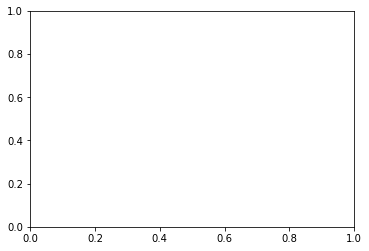

In [15]:
# Initialise variable to hold Matplotlib axes
plt_axis = 0
fig = plt.figure()
fig_ax = fig.add_axes([ 0.1,0.1,0.75,0.75], frameon=True)

In [16]:
camera = Camera(fig)

# Utility Functions

In [17]:
#Define utility functions here

def coordHash(list_x, list_y):
    hashes = []
    for i in range(len(list_x)):
        hash_res = hash_a

        hash_x_res = (hash_x*list_x[i])
        hash_y_res = (hash_y*list_y[i])
        
        if(hash_x_res<0):
            hash_x_res = hash_x_res * (-1) * hash_sgn_x
        if(hash_y_res<0):
            hash_y_res = hash_y_res * (-1) * hash_sgn_y
        
        hash_res = hash_res + hash_x_res + hash_y_res
        hash_res = hex(int(hash_res))
        hashes.append(hash_res)
    return hashes


def distEuclidArray(point_A_x, point_A_y, point_B_x, point_B_y):
    distances = np.zeros(len(point_A_x))
    for i in range(len(point_A_x)):
        distances[i]  = math.sqrt (  ( (point_A_x[i]) - (point_B_x[i]) )**2  + ( (point_A_y[i]) - (point_B_y[i])  )**2  ) 
    return distances


# Network Functions

## 4G Table Functions

In [18]:
def create4GFrame():
    #Table definition - 4G Towers

    towers_4g_columns = ['id','active', 'centre_x', 'centre_y', 'frequency', 'tx_power_dbm_4g']
    towers_4g_data = np.zeros(  shape= (num_towers_4g,len(towers_4g_columns))   )

    towers_4g = pd.DataFrame(data=towers_4g_data, columns=towers_4g_columns)


    hex_centers_4g, plt_axis = hxlat.create_hex_grid( nx=tower_grid_4g['x'],
                                                ny=tower_grid_4g['y'],
                                                min_diam= range_4g * units_per_km,
                                                edge_color=[0.8, 0.8, 0.8],
                                                h_ax=fig_ax,
                                                do_plot=False)

    ids_4g =  coordHash(hex_centers_4g[:, 0], hex_centers_4g[:, 1])

    #Initialise such that all towers initially active, no interference loss, no reuse pattern, with centres given by hex_centers_4g
    towers_4g=towers_4g.assign(id=ids_4g,active=1, frequency=freq_lte, centre_x=hex_centers_4g[:, 0], centre_y=hex_centers_4g[:, 1], tx_power_dbm_4g=link_dbm_4g)


    return towers_4g, hex_centers_4g, plt_axis


def plot4GFrame():
    hex_centers_4g, plt_axis = hxlat.create_hex_grid( nx=tower_grid_4g['x'],
                                            ny=tower_grid_4g['y'],
                                            min_diam= range_4g * units_per_km,
                                            edge_color=nw_edges_4g,
                                            face_color=nw_faces_4g,
                                            h_ax=fig_ax,
                                            do_plot=True)




def get4GBoundaries(towers_4g):

    towers_4g_range_x_even = pd.unique(towers_4g['centre_x'])[0:tower_grid_4g['x']] - (range_4g * units_per_km)/2
    towers_4g_range_x_even = np.append(  towers_4g_range_x_even, towers_4g_range_x_even[-1]+ (range_4g * units_per_km) )

    towers_4g_range_x_odd = pd.unique(towers_4g['centre_x'])[tower_grid_4g['x']:] - (range_4g * units_per_km)/2
    towers_4g_range_x_odd = np.append(  towers_4g_range_x_odd, towers_4g_range_x_odd[-1]+ (range_4g * units_per_km) )

    towers_4g_centres_y = np.sort(pd.unique(towers_4g['centre_y']))

    return towers_4g_range_x_even, towers_4g_range_x_odd, towers_4g_centres_y

## 5GNR Table Functions

In [19]:
def create5GFrame(hex_centers_5g):
    #Table definition - 4G Towers

    towers_5g_columns = ['id','active', 'centre_x', 'centre_y', 'frequency', 'tx_power_dbm_5g']
    towers_5g_data = np.zeros(  shape= (num_towers_5g,len(towers_5g_columns))   )

    towers_5g = pd.DataFrame(data=towers_5g_data, columns=towers_5g_columns)

    ids_5g =  coordHash(hex_centers_5g[:, 0], hex_centers_5g[:, 1])

    #Initialise such that all towers initially active, no interference loss, no reuse pattern, with centres given by hex_centers_5g
    towers_5g=towers_5g.assign(id=ids_5g,active=1, frequency=freq_5g, centre_x=hex_centers_5g[:, 0], centre_y=hex_centers_5g[:, 1], tx_power_dbm_5g=link_dbm_5g)


    return towers_5g, plt_axis


def plot5GFrame():
    hex_centers_5g, plt_axis = hxlat.create_hex_grid( nx=tower_grid_4g['x'],
                                            ny=tower_grid_4g['y'],
                                            min_diam= range_4g * units_per_km,
                                            plotting_gap = gap_ratio_4g_5g,
                                            edge_color=nw_edges_5g,
                                            face_color=nw_faces_5g, 
                                            h_ax=fig_ax,
                                            do_plot=True)



## Common Network Organisation Functions

In [20]:
def generateOutageLists():
    
    active_states_4g = np.random.random(size=num_towers_4g)
    active_states_4g[active_states_4g >= outage_prob_4g] = 1
    active_states_4g[active_states_4g < outage_prob_4g] =  0

    active_states_5g = np.random.random(size=num_towers_5g)
    active_states_5g[active_states_5g >= outage_prob_5g] = 1
    active_states_5g[active_states_5g < outage_prob_5g] =  0

    return active_states_4g,active_states_5g
    

## Signal Attenuation Functions

In [21]:
#Network Parameter Functions (Loss, Noise, Reception) go here

def freeSpaceLoss(freq,dist):
    loss = np.zeros(len(dist))
    dist_np = np.array(dist)
    loss = ( (-147.5522) + (20*( np.log10(freq*f_scale) + np.log10(dist_np* (1000/units_per_km)   ) ) ) ) 
    return loss



def fadingLoss():

    rayleigh_split = np.random.choice([0, 1], size=num_users, p=[.9, .1])
    rician_split = 1 - rayleigh_split

    rician_fade =   rician_mean_loss_4g         *   np.random.chisquare(df=2,size=num_users) - rician_loss_offset_db
    rayleigh_fade = rayleigh_mean_loss_4g       *   np.random.rayleigh(scale=2,size=num_users)

    rician_fade = np.multiply(rician_split,rician_fade) 
    rayleigh_fade = np.multiply(rayleigh_split,rayleigh_fade)

    fade = rician_fade + rayleigh_fade
    return fade

# Dashboarding

In [22]:
def updateDashboardData(user_data,towers_4g,towers_5g):
    
    global kpi_fail_frames

    conns_4g = user_data.loc[user_data['link_rx_4g'] > noise_floor_4g  ,'link_rx_4g']
    conns_5g = user_data.loc[user_data['link_rx_5g'] > noise_floor_5g  ,'link_rx_5g']
    users_in_red = user_data.loc[user_data['signal_strength'] == 0 ,'signal_strength']
    towers_down_4g = towers_4g[towers_4g['active'] == 0]
    towers_down_5g = towers_5g[towers_5g['active'] == 0]

    network_kpi_report['average_strength'] =  np.average(user_data['signal_strength'])
    network_kpi_report['average_rx_dbm_4g'] = np.average(conns_4g)
    network_kpi_report['average_rx_dbm_5g'] = np.average(conns_5g)
    network_kpi_report['num_users_5g'] = np.sum(user_data['using_5g'])
    network_kpi_report['num_users_4g'] = num_users - network_kpi_report['num_users_5g']
    network_kpi_report['num_users_in_red'] = len(users_in_red)
    network_kpi_report['perc_users_serviced'] = 1 - (network_kpi_report['num_users_in_red'] / num_users)
    network_kpi_report['towers_offline_4g'] = len(towers_down_4g)
    network_kpi_report['towers_offline_5g'] = len(towers_down_5g)
    if (network_kpi_report['perc_users_serviced'] < nw_kpi_threshold):
        kpi_fail_frames += iters_per_reporting_update
        network_kpi_report['kpi_fails'] = kpi_fail_frames

In [23]:
def drawDashboard():

    dashboard_string = "Network KPI Report\n\n\
                        Average Signal Strength : {:.1f}\n\
                        Average RX dBm 4G : {:.3f}\n\
                        Average RX dBm 5G : {:.3f}\n\n\
                        Total Users : {:.0f}\n\
                        4G Users : {:.0f}\n\
                        5G Users : {:.0f}\n\
                        % Users Serviced : {:.3f}%\n\n\
                        4G Towers Offline : {:.0f}\n\
                        5G Towers Offline : {:.0f}\n\n\
                        KPI Fail {:.3f}".format(        network_kpi_report['average_strength'], \
                                                            network_kpi_report['average_rx_dbm_4g'], \
                                                            network_kpi_report['average_rx_dbm_5g'], \
                                                            network_kpi_report['num_users_total'], \
                                                            network_kpi_report['num_users_4g'], \
                                                            network_kpi_report['num_users_5g'], \
                                                            network_kpi_report['perc_users_serviced']*100, \
                                                            network_kpi_report['towers_offline_4g'],\
                                                            network_kpi_report['towers_offline_5g'],\
                                                            network_kpi_report['kpi_fails']         ) 



    # these are matplotlib.patch.Patch properties
    kpi_box_props = dict(boxstyle='square', facecolor=[0.9,0.9,0.9],alpha=0.05)

    # place a text box in upper left in axes coords
    plt_axis.text(1.02, 0.6, dashboard_string, transform=plt_axis.transAxes, fontsize=4,
            verticalalignment='top', bbox=kpi_box_props)

    

# User Table Functions

In [24]:
def createUserTable():
    
    user_data_columns = ['pos_x', 'pos_y', 'vel_x', 'vel_y', 'tower', 'tower_dist', 'link_rx_4g','link_rx_5g', 'using_5g', 'signal_strength']
    user_data_rows = np.zeros(  shape= (num_users,len(user_data_columns))   )

    user_data = pd.DataFrame(data=user_data_rows, columns=user_data_columns)


    user_data=user_data.assign( pos_x   =   np.random.uniform(user_range['x_min'], user_range['x_max'],size=num_users), 
                                pos_y   =   np.random.uniform(user_range['y_min'], user_range['y_max'],size=num_users), 
                                vel_x   =   np.random.uniform(-max_vel, max_vel,size=num_users),
                                vel_y   =   np.random.uniform(-max_vel, max_vel,size=num_users)       )     


    return user_data






def getNearestTowers(user_data, towers_4g_range_x_even, towers_4g_range_x_odd, towers_4g_centres_y ):
    
    nearest_centres = np.zeros((num_users,2))
    
    for x in range(num_users):

        #print("Pos X : {} \t Pos Y : {}".format(user_data['pos_x'][x],user_data['pos_y'][x]))

        index_y= bisect.bisect_right(a=towers_4g_centres_y, x=user_data['pos_y'][x] )
        if(index_y == tower_grid_4g['y']):
            index_y-=1       
        diffs_y = [ abs((user_data['pos_y'][x] - towers_4g_centres_y[index_y-1])), abs(( user_data['pos_y'][x] - towers_4g_centres_y[index_y]))  ]
        if(diffs_y[0]<diffs_y[1]):
            index_y-=1
        nearest_centres[x,1] = towers_4g_centres_y[index_y]


    
        if(index_y%2==0):
            
            index_x = bisect.bisect_left(a=towers_4g_range_x_even, x=user_data['pos_x'][x] )
            if(index_x == 0):
                index_x += 1
            elif (index_x == len(towers_4g_range_x_even)):
                index_x -= 1
            nearest_centres[x,0] = (towers_4g_range_x_even[index_x] + towers_4g_range_x_even[index_x-1])/2
       
        else:
            index_x = bisect.bisect_left(a=towers_4g_range_x_odd, x=user_data['pos_x'][x] )
            if(index_x == 0):
                index_x += 1
            elif (index_x == len(towers_4g_range_x_odd)):
                index_x -= 1
            nearest_centres[x,0] = (towers_4g_range_x_odd[index_x] + towers_4g_range_x_odd[index_x-1])/2

        #print("Nearest X : {} \t\t Nearest Y : {}".format(nearest_centres[x,0], nearest_centres[x,1]))


    return nearest_centres


def assignTowers(user_data,nearest_centres):
    user_tower_hashes = coordHash(nearest_centres[:,0],nearest_centres[:,1])
    user_data = user_data.assign(tower = user_tower_hashes)
    user_data = user_data.assign(tower_dist=distEuclidArray(nearest_centres[:,0],nearest_centres[:,1],user_data['pos_x'],user_data['pos_y'])   )

    return user_data



def computeSignalRxes(user_data,towers_4g,towers_5g):

    towers_down_4g = towers_4g[towers_4g['active'] == 0]
    towers_down_5g = towers_5g[towers_5g['active'] == 0]


    link_4g = link_dbm_4g - freeSpaceLoss(freq_lte,user_data['tower_dist']) -fadingLoss ()
    link_5g = link_dbm_5g - freeSpaceLoss(freq_5g,user_data['tower_dist'])  -fadingLoss ()

    user_data=user_data.assign(link_rx_4g=link_4g)
    user_data=user_data.assign(link_rx_5g=link_5g)

    if(not towers_down_4g.empty):
        inactive_4g = towers_down_4g['id'].tolist()
        for tower_iter in inactive_4g:
            user_data.loc[user_data['tower'] ==  tower_iter ,'link_rx_4g'] = -999
    if(not towers_down_5g.empty):
        inactive_5g = towers_down_5g['id'].tolist()
        for tower_iter in inactive_5g:
            user_data.loc[user_data['tower'] ==  tower_iter ,'link_rx_5g'] = -999
    
    user_data.loc[user_data['link_rx_5g'] > noise_floor_5g  ,'using_5g'] = 1
    user_data.loc[user_data['link_rx_5g'] < noise_floor_5g  ,'using_5g'] = 0

    return user_data





def assignSignalStrength(user_data):
    strength_array = np.ceil( (1-user_data['using_5g']) * (user_data['link_rx_4g']-noise_floor_4g)/10)  .astype(int)
    strength_array = strength_array + np.ceil( (user_data['using_5g']) * (user_data['link_rx_5g']-noise_floor_5g)/10)  .astype(int)
    
    
    strength_array[strength_array>4 ] = 4
    strength_array[strength_array<0 ] = 0
    user_data = user_data.assign(signal_strength= strength_array)
    return user_data




def getSignalColours(strength_arr):
  length = len(strength_arr)
  face_colours = np.empty(length,dtype='object')
  edge_colours = np.empty(length,dtype='object')
  for i in range(length):
      face_colours[i] = user_faces[strength_arr[i]]
      edge_colours[i] = user_edges[strength_arr[i]]
  return face_colours,edge_colours




def createUserScatter(user_data,plt_axis,nw_type='4g'):

    if(nw_type == '4g'):
      nw_marker = marker_4g
    elif(nw_type == '5g'):
      nw_marker = marker_5g

    strength_arr = user_data['signal_strength'].values
    length = len(strength_arr)
    face_colours = np.empty(length,dtype='object')
    edge_colours = np.empty(length,dtype='object')
    for i in range(length):
      face_colours[i] = user_faces[strength_arr[i]]
      edge_colours[i] = user_edges[strength_arr[i]]


    userplot = plt_axis.scatter   (     x=user_data['pos_x'], 
                                    y=user_data['pos_y'],
                                    s=user_pltsize ,
                                    lw=0.5, 
                                    marker=nw_marker,
                                    edgecolors=edge_colours ,
                                    facecolors=face_colours  )
    return userplot



def updateUserPositions(user_data, change_vel):
    user_pos = np.zeros([num_users,2])
    

    user_data = user_data.assign(   pos_x = user_data['pos_x'] + user_data['vel_x'],
                                    pos_y = user_data['pos_y'] + user_data['vel_y']      )     
    
    
    #Teleport drifting users back within the grid, near the edge

    user_data.loc[user_data['pos_x'] > user_range['x_max']  ,'pos_x'] = user_range['x_max']
    user_data.loc[user_data['pos_x'] < user_range['x_min']  ,'pos_x'] = user_range['x_min']
    user_data.loc[user_data['pos_y'] > user_range['y_max']  ,'pos_y'] = user_range['y_max']
    user_data.loc[user_data['pos_y'] < user_range['y_min']  ,'pos_y'] = user_range['y_min']
    
    
    
    if(change_vel==0):
        user_data = user_data.assign(   vel_x   =   np.random.uniform(-max_vel, max_vel,size=num_users),
                                        vel_y   =   np.random.uniform(-max_vel, max_vel,size=num_users) ) 

    user_pos[:,0] =user_data['pos_x']
    user_pos[:,1] =user_data['pos_y']

    return user_data,user_pos

# Initialisation

Initial values may be redefined here as necessary, or removed to set them to default values defined above.

In [25]:
animation_duration_s=60
freq_lte= 1.5
freq_5g = 10
outage_prob_4g = 0.000
outage_prob_5g = 0.1
output_file='model-output.mp4'

In [26]:
towers_4g, hex_centers_4g, plt_axis = create4GFrame()
towers_5g, plt_axis = create5GFrame(hex_centers_4g)
towers_4g_range_x_even, towers_4g_range_x_odd, towers_4g_centres_y = get4GBoundaries(towers_4g)

user_data = createUserTable()

nearest_centres = getNearestTowers(user_data, towers_4g_range_x_even, towers_4g_range_x_odd, towers_4g_centres_y )
user_data = assignTowers(user_data,nearest_centres)
user_data = computeSignalRxes(user_data,towers_4g,towers_5g)

#updateDashboardData(user_data,towers_4g,towers_5g)

# Main Loop

In [27]:

for i in range( int (animation_duration_s/seconds_per_frame) ):
    
    #Update user positions every iteration, and user velocities every "moves_before_vel_change" iterations
    user_data,user_pos = updateUserPositions(user_data, change_vel=((i+1)%moves_before_vel_change))
    
    #For every iters_per_outage_update, select 4G & 5G cells to go offline
    if(i % iters_per_outage_update == 0):
        active_states_4g, active_states_5g = generateOutageLists()
        towers_4g=towers_4g.assign(active=active_states_4g)
        towers_5g=towers_5g.assign(active=active_states_5g)

   



    #Get nearest pair of 4G/5G towers for each user, and set as active tower
    nearest_centres = getNearestTowers(user_data, towers_4g_range_x_even, towers_4g_range_x_odd, towers_4g_centres_y )
    user_data = assignTowers(user_data,nearest_centres)
    
    #Determine received signal for each user for both 4G and 5G networks, factoring path loss. Select 5G network if signal strength is above Minimum Detectable Signal
    user_data = computeSignalRxes(user_data,towers_4g,towers_5g)
    user_data = assignSignalStrength(user_data)
    
    #For every iters_per_reporting_update, refresh dashboard data
    if(i % iters_per_reporting_update == 0):
            updateDashboardData(user_data,towers_4g,towers_5g)    



    #Plot 4G and 5G lattices
    plot4GFrame()
    plot5GFrame()

    drawDashboard()
    #Plot users, separately for 4g (o) and 5g (^)
    createUserScatter(   user_data[ user_data['using_5g'] ==0 ]  ,plt_axis, nw_type='4g')
    createUserScatter(   user_data[ user_data['using_5g'] ==1 ]  ,plt_axis, nw_type='5g')

    #Animation capture trigger
    camera.snap()
    


In [28]:
animation = camera.animate()
#HTML(animation.to_html5_video())

animation.save(output_file,    dpi=300, savefig_kwargs={'pad_inches': 'tight' }              )